# Data Analytics project : Option Pricing 

This is a notebook for analyzing a data from SET50 index options from 2019 to 2021. The data set is collected manually by myself in 2019. Back there in 2019 I have no idea what Python or Data Analytics are. Still, to understand Options beheavior, I chose to collect the data by hand. Every single day at market close, I would open this Google Sheet and jotted all the numbers. The medhod was prone to human errors but back then I havn't heard about web-scraping. 

Here is what it looks like.


![options_sheet](options_sheet.png)

Options is a derivative origanally aim to be used as an insurance for an underlying asset volatility during a certain period of time. And just like any insurances, the buyer need to pay the insurance premium to get insured, but, a million dollar question is, "How much" you should pay or sell for an option at a certain time.

Since Options premium depends a lot on: 
- underlying's volatility and 
- time to expiration 
This notebook thus aim to map Options premium to both of the factors.

For anyone who want to learn more about Options, here's a [link](https://www.investopedia.com/terms/s/stockoption.asp) to lay some foundation. 

----------------

**Thailand Future Exchange(TFEX)** is a derivative market wich provides wide range of derivative such as "Index Future" and "Index Options". Each contracts expired at the end of each quarters and coded by the letter and numbers. Here is how to read the contract symbol:

 * S50H20 -> Means: this is an SET50 Index Future Expired at March 2020.
 
 * S50M20C900 -> Means: this is an SET50 Index Options at Strike Price 900 Expired at June 2020.
 
 The month code are as follows:
 
 * H -> March Expiration
 * M -> June Expiration
 * U -> September Expiration
 * Z -> December Expiration
 
 Thus **S50U22** is an **SET50 Index Future Contract expired at September 2022.**
 
 
 For more detailed explanation, please visit the [exchange](https://www.tfex.co.th/tfex/index.html?locale=en_US) tutorial.

-----------------------

Thanak Rattanopastkul, 2022

### Import dependencies

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Read the dataset

In [57]:
import os

os.getcwd()
path = os.getcwd()+'/option_premium.csv'

raw_data = pd.read_csv(path, 
                  parse_dates=['date','Expiration'],
                  infer_datetime_format=True,
                  dayfirst=True
)

In [7]:
preprocess = raw_data.copy()
preprocess.head()

,date,Series Name,Underlying Close,Expiration,Day to expire,Underlying Change,ATM premium,+/-1 OTM premium
0,2019-06-18,U19,1111.8,2019-09-27,101d,NaN,38.8,20.9
1,2019-06-19,U19,1131.2,2019-09-27,100d,19.4,39.4,22.1
2,2019-06-20,U19,1144.4,2019-09-27,99d,13.2,44.7,24.8
3,2019-06-21,U19,1141.6,2019-09-27,98d,-2.8,47.0,26.7
4,2019-06-24,U19,1139.2,2019-09-27,95d,-2.4,48.6,28.0


In [8]:
preprocess.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595 entries, 0 to 594
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               595 non-null    datetime64[ns]
 1   Series Name        595 non-null    object        
 2   Underlying Close   594 non-null    float64       
 3   Expiration         595 non-null    datetime64[ns]
 4   Day to expire      595 non-null    object        
 5   Underlying Change  585 non-null    float64       
 6   ATM premium        592 non-null    float64       
 7   +/-1 OTM premium   595 non-null    float64       
dtypes: datetime64[ns](2), float64(4), object(2)
memory usage: 37.3+ KB


### Data cleanning

As mentioned above, This manually collected dataset is prone to human error. Let's make sure that the data is clean and validated.
### Missing Data and Data Validation

In [9]:
preprocess.isna().sum()

date                  0
Series Name           0
Underlying Close      1
Expiration            0
Day to expire         0
Underlying Change    10
ATM premium           3
+/-1 OTM premium      0
dtype: int64

Fist, let's fix the missing Underlying Change. This missing is mostly due to the fact that it is the first trading day for the contract. Thus, it has no change. Let's set these missing change to zero. 

In [10]:
preprocess.loc[preprocess['Underlying Change'].isna()]

,date,Series Name,Underlying Close,Expiration,Day to expire,Underlying Change,ATM premium,+/-1 OTM premium
0,2019-06-18,U19,1111.8,2019-09-27,101d,NaN,38.8,20.9
71,2019-09-16,Z19,1102.0,2019-12-27,102d,NaN,59.6,38.5
136,2019-12-17,H20,1048.8,2020-03-30,104d,NaN,47.6,27.7
204,2020-03-23,M20,663.1,2020-06-29,98d,NaN,NaN,119.0
270,2020-06-22,U20,892.0,2020-09-29,99d,NaN,99.0,83.0
335,2020-09-29,U20,NaN,2020-09-29,0ms,NaN,5.2,0.3
336,2020-09-21,Z20,813.4,2020-12-29,99d,NaN,59.8,39.0
400,2020-12-22,H21,904.9,2021-03-30,98d,NaN,94.8,77.0
466,2021-03-25,M21,955.5,2021-06-29,96d,NaN,62.2,43.1
526,2021-06-18,U21,967.0,2021-09-29,103d,NaN,53.1,34.2


There are couple of missing data for Underlying Change. All of them are either at the beginning of data collection or at the last trading day. Let's set them to zero.

In [11]:
preprocess.loc[preprocess['Underlying Change'].isna(),'Underlying Change'] = 0

Next, the missing underlying close. This is easy to fix since the S50 Future price is public data.

Let's see where is the missing one.

In [12]:
preprocess.loc[preprocess['Underlying Close'].isna()]

,date,Series Name,Underlying Close,Expiration,Day to expire,Underlying Change,ATM premium,+/-1 OTM premium
335,2020-09-29,U20,NaN,2020-09-29,0ms,0.0,5.2,0.3


Need to find the closing of H50U20 at 2020-09-29. I use [tradingview](https://th.tradingview.com/chart/) to check for the missing price. Which is 793.9.

In [13]:
# double check of 793.9 is making sense
preprocess.loc[333:337]
# Those "Close" need to be close to 793.9. Checked.

,date,Series Name,Underlying Close,Expiration,Day to expire,Underlying Change,ATM premium,+/-1 OTM premium
333,2020-09-25,U20,784.1,2020-09-29,4d,-0.5,16.0,2.3
334,2020-09-28,U20,799.7,2020-09-29,1d,15.6,7.6,0.6
335,2020-09-29,U20,NaN,2020-09-29,0ms,0.0,5.2,0.3
336,2020-09-21,Z20,813.4,2020-12-29,99d,0.0,59.8,39.0
337,2020-09-22,Z20,808.5,2020-12-29,98d,-4.9,50.0,32.4


In [14]:
preprocess.loc[335,'Underlying Close'] = 793.9

In [15]:
preprocess.loc[334:336]

,date,Series Name,Underlying Close,Expiration,Day to expire,Underlying Change,ATM premium,+/-1 OTM premium
334,2020-09-28,U20,799.7,2020-09-29,1d,15.6,7.6,0.6
335,2020-09-29,U20,793.9,2020-09-29,0ms,0.0,5.2,0.3
336,2020-09-21,Z20,813.4,2020-12-29,99d,0.0,59.8,39.0


also need to fix "Underlying Change" for entry 335 and 336 too.

In [16]:
preprocess.loc[335, 'Underlying Change'] = preprocess.loc[335, 'Underlying Close']-preprocess.loc[334, 'Underlying Close']
preprocess.loc[336, 'Underlying Change'] = preprocess.loc[336, 'Underlying Close']-preprocess.loc[335, 'Underlying Close']

In [17]:
preprocess.loc[335:337]

,date,Series Name,Underlying Close,Expiration,Day to expire,Underlying Change,ATM premium,+/-1 OTM premium
335,2020-09-29,U20,793.9,2020-09-29,0ms,-5.8,5.2,0.3
336,2020-09-21,Z20,813.4,2020-12-29,99d,19.5,59.8,39.0
337,2020-09-22,Z20,808.5,2020-12-29,98d,-4.9,50.0,32.4


Entey 335,336 is done.

Finally, the missing "at the money" premium which are missing.

In [18]:
preprocess.loc[preprocess['ATM premium'].isna()]

,date,Series Name,Underlying Close,Expiration,Day to expire,Underlying Change,ATM premium,+/-1 OTM premium
188,2020-03-09,H20,822.3,2020-03-30,21d,-92.3,NaN,0.0
191,2020-03-12,H20,724.1,2020-03-30,18d,-97.6,NaN,0.0
204,2020-03-23,M20,663.1,2020-06-29,98d,0.0,NaN,119.0


For the entries at 

* 2020-03-09 
* 2020-03-12
* 2020-03-23 

those are very special case when COVID-19 crash the global market. The market actually crash and [Circuit Breaker](https://www.investopedia.com/terms/c/circuitbreaker.asp) was implimented on those three days. The Options market maker stop providing liquidity. Thus, those three very rare occasions should be left as NaN.

Check if all the missing data has been taking cared off.

In [19]:
preprocess.isna().sum()

date                 0
Series Name          0
Underlying Close     0
Expiration           0
Day to expire        0
Underlying Change    0
ATM premium          3
+/-1 OTM premium     0
dtype: int64

All the missing data but the last 3 cercuit breaks are dealth with.

Now let's validate the data. Let's check that "Day to expire" and "Underlying Change" was collected correctly.

In [20]:
preprocess['Validate_DTE'] = preprocess['Expiration']-preprocess['date']

In [21]:
# see if 'Validate_DTE'and 'Day to expire' are different in any line?
preprocess.loc[preprocess['Validate_DTE']!=preprocess['Day to expire']]

,date,Series Name,Underlying Close,Expiration,Day to expire,Underlying Change,ATM premium,+/-1 OTM premium,Validate_DTE


"Day to expire" column are collected correctly.

In [22]:
# drop the old column. Using the validate column
preprocess.drop('Day to expire',axis=1, inplace=True)

Check the calculation of Underlying Change.

In [23]:
for i in preprocess.index[1:]:
    if preprocess.loc[i, 'Series Name'] == preprocess.loc[i-1, 'Series Name']:
        preprocess.loc[i, 'validate_change'] = preprocess.loc[i, 'Underlying Close']-preprocess.loc[i-1, 'Underlying Close']
    else:
        preprocess.loc[i, 'validate_change'] = 0

Let's see where the data discrepancy still exist between 'Underlying Change' and 'validate_change'

In [24]:
preprocess[~np.isclose(preprocess['Underlying Change'],preprocess['validate_change'])]

,date,Series Name,Underlying Close,Expiration,Underlying Change,ATM premium,+/-1 OTM premium,Validate_DTE,validate_change
0,2019-06-18,U19,1111.8,2019-09-27,0.0,38.8,20.9,101 days,NaN
336,2020-09-21,Z20,813.4,2020-12-29,19.5,59.8,39.0,99 days,0.0


Only for the first entry, it doesn't have anything prior to compare with. Let's set zero it.

In [25]:
preprocess.loc[0, 'validate_change'] = 0

In [26]:
# drop the old change column
preprocess.drop('Underlying Change', axis=1, inplace=True)

### Feature Engineering

One thing that is alway in use to gauge volatility are price range and daily return (percent change over intervals). 

On the other side, the premium lag and premium change is worth calculating too.

Let's calculate these column. 

In [27]:
preprocess['daily return'] = (preprocess['Underlying Close']-preprocess['Underlying Close'].shift(1))/preprocess['Underlying Close'].shift(1)
preprocess['range'] = preprocess['Underlying Close'] - preprocess['Underlying Close'].shift(1)
preprocess['atm_change'] = preprocess['ATM premium'] - preprocess['ATM premium'].shift(1)
preprocess['otm_change'] = preprocess['+/-1 OTM premium'] - preprocess['+/-1 OTM premium'].shift(1)
preprocess['atm_lag'] = preprocess['ATM premium'].shift(1)
preprocess['+/-1 Otm_lag'] = preprocess['+/-1 OTM premium'].shift(1)

In [28]:
preprocess.head(3)

,date,Series Name,Underlying Close,Expiration,ATM premium,+/-1 OTM premium,Validate_DTE,validate_change,daily return,range,atm_change,otm_change,atm_lag,+/-1 Otm_lag
0,2019-06-18,U19,1111.8,2019-09-27,38.8,20.9,101 days,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-06-19,U19,1131.2,2019-09-27,39.4,22.1,100 days,19.4,0.017449,19.4,0.6,1.2,38.8,20.9
2,2019-06-20,U19,1144.4,2019-09-27,44.7,24.8,99 days,13.2,0.011669,13.2,5.3,2.7,39.4,22.1


Now, the percent change from yesterday is ready.

### Time for EDA

In [29]:
preprocess.tail(3)

,date,Series Name,Underlying Close,Expiration,ATM premium,+/-1 OTM premium,Validate_DTE,validate_change,daily return,range,atm_change,otm_change,atm_lag,+/-1 Otm_lag
592,2021-09-27,U21,970.2,2021-09-29,10.1,1.0,2 days,3.4,0.003517,3.4,-6.2,-1.8,16.3,2.8
593,2021-09-28,U21,968.6,2021-09-29,8.5,0.6,1 days,-1.6,-0.001649,-1.6,-1.6,-0.4,10.1,1.0
594,2021-09-29,U21,970.2,2021-09-29,4.4,0.2,0 days,1.6,0.001652,1.6,-4.1,-0.4,8.5,0.6


In [30]:
preprocess.describe()

,Underlying Close,ATM premium,+/-1 OTM premium,Validate_DTE,validate_change,daily return,range,atm_change,otm_change,atm_lag,+/-1 Otm_lag
count,595.000000,592.000000,595.000000,595,595.000000,594.000000,594.000000,588.000000,594.000000,591.000000,594.000000
mean,949.979496,48.614865,30.184202,50 days 06:34:29.243697479,-0.152101,-0.000081,-0.238384,-0.369898,-0.034848,48.689679,30.234680
std,107.235427,27.415832,25.722697,29 days 18:35:24.032951502,14.193315,0.017107,14.557773,8.006717,8.820449,27.378508,25.714865
min,663.100000,1.600000,0.000000,0 days 00:00:00,-97.600000,-0.118778,-97.600000,-24.200000,-35.800000,1.600000,0.000000
25%,878.450000,33.700000,15.500000,25 days 00:00:00,-6.000000,-0.006550,-6.075000,-2.700000,-1.900000,33.800000,15.550000
50%,947.300000,43.500000,24.300000,49 days 00:00:00,0.000000,0.000107,0.100000,-1.100000,-0.800000,43.500000,24.350000
75%,1058.250000,55.575000,35.150000,76 days 00:00:00,6.400000,0.006845,6.600000,0.400000,0.100000,55.650000,35.225000
max,1157.200000,162.000000,146.600000,104 days 00:00:00,72.500000,0.105378,72.500000,97.400000,118.600000,162.000000,146.600000


In [31]:
preprocess['Series Name'].unique()

array(['U19', 'Z19', 'H20', 'M20', 'U20', 'Z20', 'H21', 'M21', 'U21'],
      dtype=object)

### EDA Overview

This is a data collected during a Pandemic Market Crash. The price of any assets tend to fluctuate more violently compared to the normal situation.

* Overall, There Are 592 "Observations from 2019-2021.
* There are 9 different Series along those 2 years from U19 to U21. (Q3 2019 to Q3 2021)

First of all let's plot the underlying price. This is the SET50 Index Future Contract nearest expiration price.

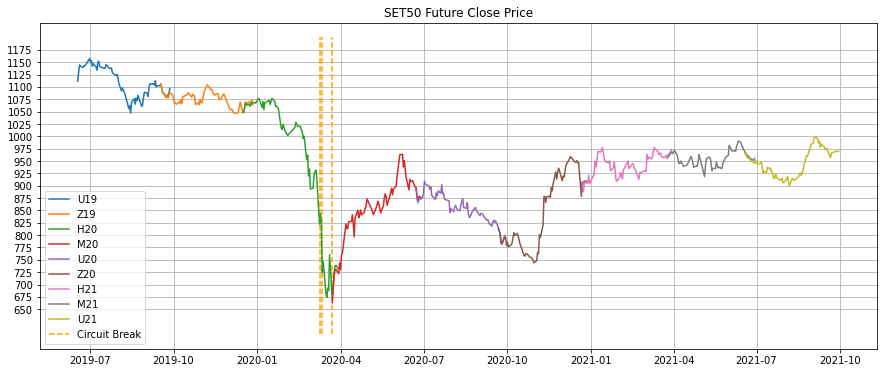

In [32]:
interval = [i*25 for i in range(26,48)]

ax,fig = plt.subplots(figsize=(15,6))
for symbol in preprocess['Series Name'].unique():
    plt.plot(preprocess.loc[preprocess['Series Name'] == symbol, 'date'],
                preprocess.loc[preprocess['Series Name'] == symbol, 'Underlying Close'],label=symbol)
plt.title('SET50 Future Close Price')
plt.grid()
plt.yticks(interval)
plt.vlines(['2020-03-09','2020-03-12','2020-03-23'],ymin=600,ymax=1200,label='Circuit Break',linestyles='dashed',colors='orange')
plt.legend()
plt.show()

From 592 observations, The most prominent characteristic from SET50 Future closing price was that the steep drop at Q1 2020. The global market has been hit so hard with the COVID-19 and most market crashed including Thai stock market.

However, after 3 consecutive Circuit Breaks, the market rebounded stedily.

Again, the objective of this notebook is to explore the Options price, which partly derived from the volatility of the underlying (SET50 Index Future Closing Price). Thus, let's take a look at the distribution of all closing price.

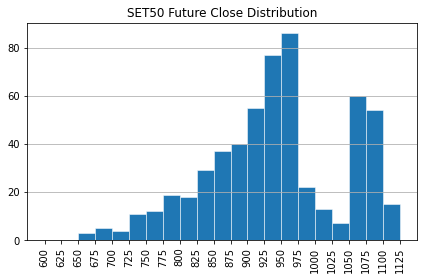

In [33]:
interval = [i*25 for i in range(24,46)]

fig = plt.subplots(figsize=(7,4))
plt.grid(axis='y')
plt.title('SET50 Future Close Distribution')
plt.hist(preprocess['Underlying Close'],bins=interval,orientation='vertical',linewidth=0.5,edgecolor='white')
plt.xticks(interval,rotation=90)

plt.show()

Price clustered around 900-975 and 1050-1100. However the left skew is due to the Global Crash. At the Crash, the lowest Close was around 675.

### Now, lets explore the option price.



______
Note: "ATM premium" and "+/-1 OTM premium" mean "Combined Put and Call premium at ATM" and "Combined 1 strike lower Put and 1 strike higher Call premium" respectlively.

### Option Price by Series.

Let's begin with plotting total ATM and +/-1 OTM premium on daily basis.

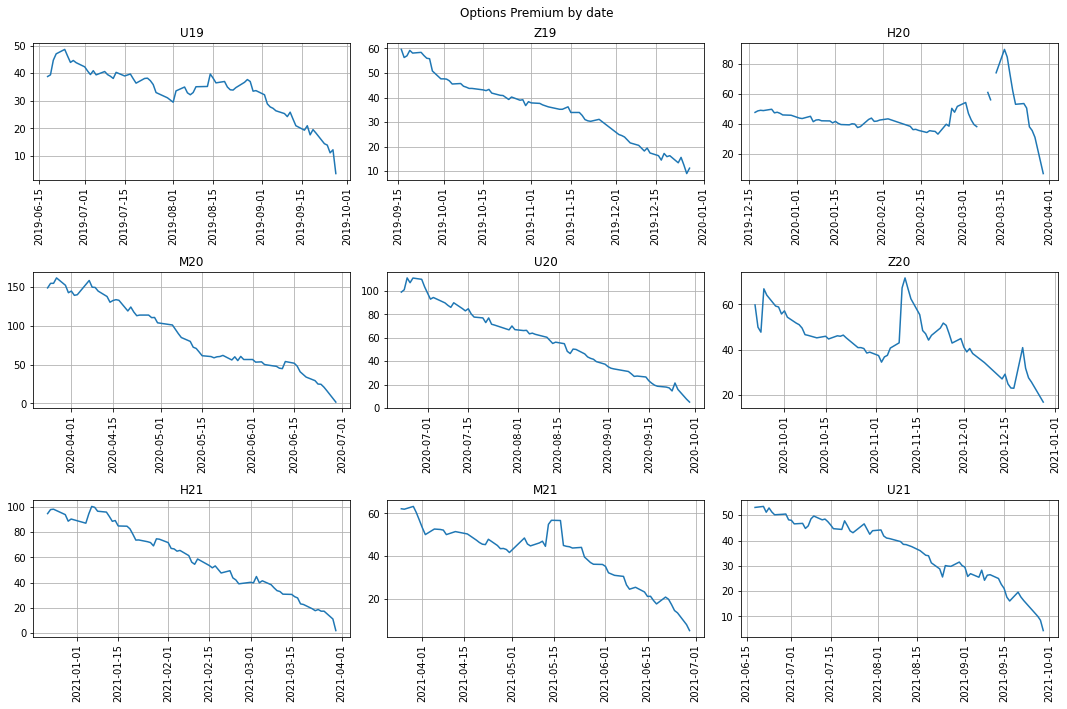

In [34]:
fig = plt.figure(figsize=(15,10))
for i,symbol in enumerate(preprocess['Series Name'].unique()):
    plt.subplot(3,3,i+1)
    plt.suptitle('Options Premium by date')
    plt.title(symbol)
    plt.tight_layout()
    plt.plot(preprocess.loc[preprocess['Series Name'] == symbol, 'date'],
             preprocess.loc[preprocess['Series Name'] == symbol, 'ATM premium'],label=symbol)
    plt.grid()
    plt.xticks(rotation=90)

### Let's see how much Options worth from begining to the expiration.

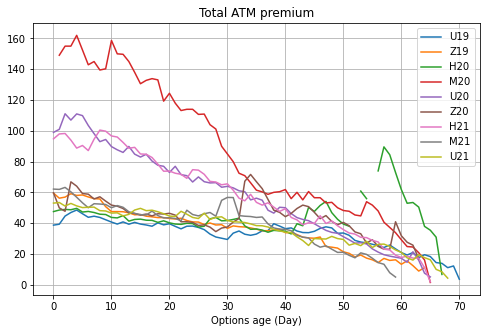

In [35]:
fig = plt.figure(figsize=(8,5))
for serie in preprocess['Series Name'].unique():
    interval = range(len(preprocess.loc[preprocess['Series Name'] == serie]))
    plt.plot(interval, preprocess.loc[preprocess['Series Name'] == serie, 'ATM premium'],label = serie)
plt.title('Total ATM premium')
plt.xlabel('Options age (Day)')
plt.grid()
plt.legend()
plt.show()

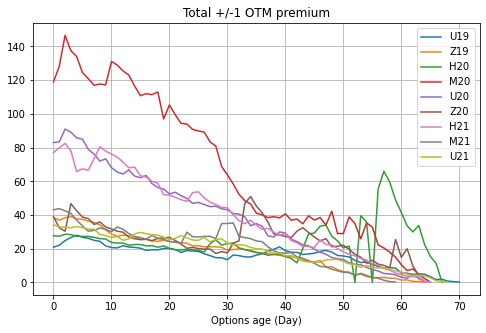

In [36]:
fig = plt.figure(figsize=(8,5))
for serie in preprocess['Series Name'].unique():
    interval = range(len(preprocess.loc[preprocess['Series Name'] == serie]))
    plt.plot(interval, preprocess.loc[preprocess['Series Name'] == serie, '+/-1 OTM premium'],label = serie)
plt.title('Total +/-1 OTM premium')
plt.xlabel('Options age (Day)')
plt.grid()
plt.legend()
plt.show()

Considering both of the plot, there are 4 clusters:
     
   * **The COVID Crash** - Which have very high premium. 
       * M20
   * **The Transition** - Between Normal Market and Volatile Market -  High Premium Spike at the transition.
       * Late H20
       * Late Z20
   * **The Hi Underlying Volatility**
       * U20
       * H21
   * **The Normal Market**
       * All the Others: U19, Z19, M21, U21
       
The ATM is naturally more expensive than +/-1 OTM premium from the higher Intrinsic values while OTM only process time value with zero intrinsic value. 
       
Let's take a snap shot at **91,90,89,61,60,59,31,30,29** days to expiration to see the premium level at each category (Just in case that the exact 90/60,30 are a holiday so I add a day before and after to the analysis).

### Scatterplot at month beginning

In [37]:
import datetime as dt

crash_series = ['M20']
trans_series = ['H20', 'Z20']
hi_vol_series = ['U20','H21']
normal_series = ['U19','Z19','M21','U21']

snap = [pd.to_timedelta(i, unit='d')for i in [91,90,89,61,60,59,31,30,29]]
for_scatter = preprocess.loc[preprocess['Validate_DTE'].isin(snap)]

condition = [
    for_scatter['Series Name'].isin(crash_series),
    for_scatter['Series Name'].isin(trans_series),
    for_scatter['Series Name'].isin(hi_vol_series),
    for_scatter['Series Name'].isin(normal_series),   
]

category = ['crash_series','trans_series','hi_vol_series','normal_series']

for_scatter['category'] = np.select(condition,category) #poppulate a column with a conditional array

/var/folders/2c/ftb5blb955vg1y_ch6hdt1_h0000gn/T/ipykernel_3072/3239277814.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_scatter['category'] = np.select(condition,category) #poppulate a column with a conditional array


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


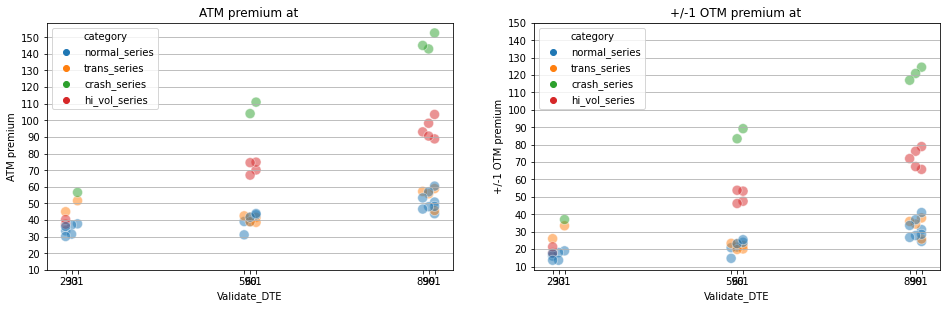

In [39]:
import seaborn as sns

fig = plt.figure(figsize=(16,10))
plt.subplot(221)
sns.scatterplot(for_scatter['Validate_DTE'].dt.days,for_scatter['ATM premium'],data=for_scatter,hue='category',s=100,alpha=0.5,)
plt.title('ATM premium at ')
plt.xticks([91,90,89,61,60,59,31,30,29])
plt.yticks(np.arange(10,160,10))
plt.grid(axis='y')

plt.subplot(222)
sns.scatterplot(for_scatter['Validate_DTE'].dt.days,for_scatter['+/-1 OTM premium'],data=for_scatter,hue='category',s=100,alpha=0.5,)
plt.title('+/-1 OTM premium at ')
plt.xticks([91,90,89,61,60,59,31,30,29])
plt.yticks(np.arange(10,160,10))
plt.grid(axis='y')


plt.show()

At the beginning of each month Crash Series and Hi Vol Series have a very distinct price
* ##### At 90 days to expirataion
    * Crash ATM -> around 148 : Crash OTM -> around 120
    * Hi_vol ATM -> around 95 : Hi_vol OTM -> around 72
    * Normal and trans ATM -> around 50 : Normal and trans OTM -> around 35
* ##### At 60 to expirataion
    * Crash ATM -> around 110 : Crash OTM -> around 85
    * Hi_vol ATM -> around 75 : Hi_vol OTM -> around 50
    * Normal and trans ATM -> around 40 : Normal and trans OTM -> around 20
* ##### At 30 to expirataion 
    at this stage the time decay will have a very big effect on price. We would see a steep drop in options premium.
    
    * Crash ATM -> around 60 : Crash OTM -> around 40
    * Hi_vol ATM -> around 40 : Hi_vol OTM -> around 20
    * Normal ATM-> around 35 : NormalOTM -> around 15
    * Transistion ATM-> around 50 : Transistion OTM -> around 30 
      (since the Volatility Spike, so does the premium for Tansition Serie)


### Quantify the volatility

The above plots show the rough overview of the option pricing effected by time to maturity and underlying volatility. However, the latter has been only categorized by loonking back. Looking foward is another story. Since we don't know the future, to model an option pricing both volatility and time to exporation should be quantify. Day to Expiration is easy. Let's explore the simple quantification for underlying volatility.

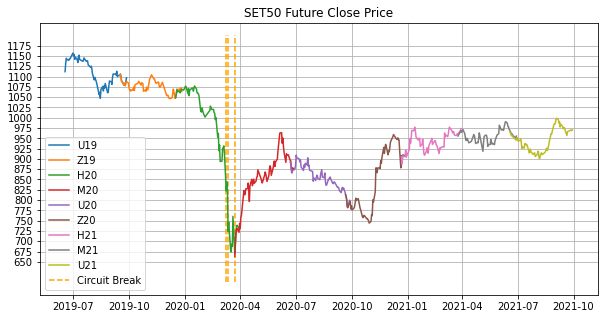

In [40]:
interval = [i*25 for i in range(26,48)]

ax,fig = plt.subplots(figsize=(10,5))
for symbol in preprocess['Series Name'].unique():
    plt.plot(preprocess.loc[preprocess['Series Name'] == symbol, 'date'],
                preprocess.loc[preprocess['Series Name'] == symbol, 'Underlying Close'],label=symbol)
plt.title('SET50 Future Close Price')
plt.grid()
plt.yticks(interval)
plt.vlines(['2020-03-09','2020-03-12','2020-03-23'],ymin=600,ymax=1200,label='Circuit Break',linestyles='dashed',colors='orange')
plt.legend()
plt.show()

From the historical price chart above, One way to simply express the price movement is to show it in term of price range and percentage return.

those price feature and some other features have already been calculated in feature engineering section

Let's check missing values

In [41]:
preprocess.isna().sum()

date                0
Series Name         0
Underlying Close    0
Expiration          0
ATM premium         3
+/-1 OTM premium    0
Validate_DTE        0
validate_change     0
daily return        1
range               1
atm_change          7
otm_change          1
atm_lag             4
+/-1 Otm_lag        1
dtype: int64

Those missings mostly came from the 3 missing ATM at the COVID circuit breaker, and being the first entry in the dataset.

In [42]:
preprocess.loc[preprocess['atm_change'].isna()]

,date,Series Name,Underlying Close,Expiration,ATM premium,+/-1 OTM premium,Validate_DTE,validate_change,daily return,range,atm_change,otm_change,atm_lag,+/-1 Otm_lag
0,2019-06-18,U19,1111.8,2019-09-27,38.8,20.9,101 days,0.0,NaN,NaN,NaN,NaN,NaN,NaN
188,2020-03-09,H20,822.3,2020-03-30,NaN,0.0,21 days,-92.3,-0.100918,-92.3,NaN,-21.6,38.1,21.6
189,2020-03-10,H20,843.7,2020-03-30,60.9,39.6,20 days,21.4,0.026025,21.4,NaN,39.6,NaN,0.0
191,2020-03-12,H20,724.1,2020-03-30,NaN,0.0,18 days,-97.6,-0.118778,-97.6,NaN,-35.8,56.0,35.8
192,2020-03-13,H20,747.0,2020-03-30,74.0,55.4,17 days,22.9,0.031625,22.9,NaN,55.4,NaN,0.0
204,2020-03-23,M20,663.1,2020-06-29,NaN,119.0,98 days,0.0,-0.093259,-68.2,NaN,118.6,6.8,0.4
205,2020-03-24,M20,690.2,2020-06-29,149.1,128.3,97 days,27.1,0.040869,27.1,NaN,9.3,NaN,119.0


Let's set zero all the first entry

In [43]:
preprocess.loc[preprocess['daily return'].isna()]

,date,Series Name,Underlying Close,Expiration,ATM premium,+/-1 OTM premium,Validate_DTE,validate_change,daily return,range,atm_change,otm_change,atm_lag,+/-1 Otm_lag
0,2019-06-18,U19,1111.8,2019-09-27,38.8,20.9,101 days,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
preprocess.loc[0 , 'daily return'] = 0
preprocess.loc[0 , 'range'] = 0
preprocess.loc[0 , 'atm_change'] = 0
preprocess.loc[0 , 'otm_change'] = 0
preprocess.loc[0 , 'atm_lag'] = 0
preprocess.loc[0 , '+/-1 Otm_lag'] = 0

In [45]:
preprocess.loc[0]

date                2019-06-18 00:00:00
Series Name                         U19
Underlying Close                 1111.8
Expiration          2019-09-27 00:00:00
ATM premium                        38.8
+/-1 OTM premium                   20.9
Validate_DTE          101 days 00:00:00
validate_change                     0.0
daily return                        0.0
range                               0.0
atm_change                          0.0
otm_change                          0.0
atm_lag                             0.0
+/-1 Otm_lag                        0.0
Name: 0, dtype: object

preprocess.isna().sum()

the missing data are left with only those caused by the Circuit Breaker. They are such a rare event. Let's drop them.



In [46]:
preprocess.dropna(inplace=True)

In [47]:
preprocess.describe()

,Underlying Close,ATM premium,+/-1 OTM premium,Validate_DTE,validate_change,daily return,range,atm_change,otm_change,atm_lag,+/-1 Otm_lag
count,589.000000,589.000000,589.000000,589,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000
mean,952.032937,48.380306,29.910526,50 days 07:49:24.346349745,0.047538,0.000283,0.076570,-0.369270,-0.316129,48.683701,30.191171
std,105.612700,27.145585,25.183632,29 days 16:29:08.006504926,13.035275,0.015273,13.124922,7.999921,6.590484,27.438991,25.499554
min,671.000000,1.600000,0.200000,0 days 00:00:00,-89.500000,-0.117686,-89.500000,-24.200000,-16.000000,0.000000,0.000000
25%,881.600000,33.700000,15.500000,25 days 00:00:00,-6.000000,-0.006385,-6.000000,-2.700000,-1.900000,33.700000,15.700000
50%,947.800000,43.300000,24.200000,50 days 00:00:00,0.000000,0.000105,0.100000,-1.100000,-0.800000,43.500000,24.400000
75%,1058.500000,55.200000,34.900000,76 days 00:00:00,6.000000,0.006752,6.600000,0.400000,0.100000,55.500000,35.000000
max,1157.200000,162.000000,146.600000,104 days 00:00:00,72.500000,0.105378,72.500000,97.400000,82.700000,162.000000,146.600000


### Effect of volatility on Options premium.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='daily return', ylabel='atm_change'>

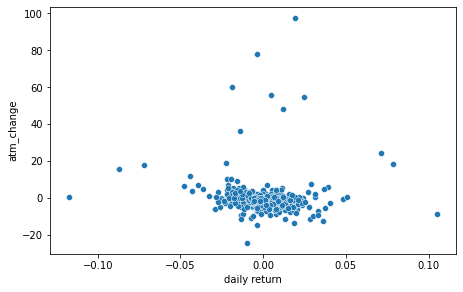

In [ ]:
fig = plt.figure(figsize=(16,10))
plt.subplot(221)

sns.scatterplot(preprocess['daily return'],preprocess['atm_change'])

In [53]:
#current working cell